# Aplicaciones de Aprendizaje Automático sobre Spotify 

## Propósito del documento

El objetivo del documento es explicar la aplicación de diferentes técnicas de aprendizaje automático sobre el dataset de [Spotify Tracks DB](https://www.kaggle.com/zaheenhamidani/ultimate-spotify-tracks-db). El objetivo del proyecto será estudiar diferentes configuraciones de las técnicas  para determinar la popularidad que tendrá una canción.

## Descripción del Dataset

El dataset tiene un tamaño de 32,15 MB, contiene 232,725 pistas de música. Los datos para cada una de las pistas de música son los siguientes:
- **Genre**: Género (Película, Jazz, Reggaeton...)
- **artist_name**: Nombre del artista
- **track_name**: Nombre de la pista
- **track_id**: El id de Spotify para la pista.
- **Popularity**: Ínidice de popularidad de una pista (0- 100)
- **Acousticness**: Una medida de confianza de 0.0 a 1.0 de si la pista es acústica. 1,0 representa una alta confianza de que la pista es acústica.
- **Danceability**: describe lo adecuado que es un tema para el baile basado en una combinación de elementos musicales como el tempo, la estabilidad del ritmo, la fuerza del compás y la regularidad general. Un valor de 0.0 es el menos bailable y 1.0 es el más bailable. 
- **Duration_ms**: La duración de la pista en milisegundos.  
- **Energy**: La energía es una medida de 0,0 a 1,0 y representa una medida perceptiva de la intensidad y la actividad. Típicamente, las huellas de energía se sienten rápidas, fuertes y ruidosas.
- **Instrumentalness**: Predice si una pista no contiene voces. Los sonidos "Ooh" y "aah" son tratados como instrumentales en este contexto. Las pistas de rap o de palabra hablada son claramente "vocales". 
- **Key**: La clave general estimada de la pista. Los números enteros se asignan a los lanzamientos usando la notación estándar de la clase de lanzamiento. Por ejemplo, 0 = C, 1 = C♯/D♭, 2 = D, y así sucesivamente. Si no se detectó ninguna clave, el valor es -1.
- **Liveness**: Detecta la presencia de una audiencia en la grabación ( 1 música en concierto)
- **Loudness**: La sonoridad global de una pista en decibelios (dB)
- **Mode**: El modo indica la modalidad (mayor o menor) de una pista, el tipo de escala de la que se deriva su contenido melódico. La mayor se representa por 1 y la menor por 0. 
- **Speechiness**:  detecta la presencia de palabras habladas en una pista
- **Tempo**: El tempo global estimado de una pista en pulsaciones por minuto (BPM). En la terminología musical, el tempo es la velocidad o el ritmo de una pieza dada y se deriva directamente de la duración media del tiempo
- **Time_signature**: Una firma de tiempo global estimada de una pista. La signatura de tiempo (metro) es una convención notacional para especificar cuántos latidos hay en cada barra (o medida).
- **Valence**: Una medida de 0.0 a 1.0 que describe la positividad musical transmitida por una pista (1 muy positivo)

## Librerías

In [101]:
!pip install --upgrade category_encoders

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Requirement already up-to-date: category_encoders in /home/rvindel/anaconda3/lib/python3.7/site-packages (2.2.2)
You should consider upgrading via the '/home/rvindel/anaconda3/bin/python -m pip install --upgrade pip' command.


In [102]:
import pandas as pd
import numpy as np
from numpy import argmax
from sklearn.preprocessing import LabelBinarizer
import numpy.ma as ma
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from scipy import optimize

from numpy import inf
from pandas.io.parsers import read_csv
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')

###########################
####     OUR CLASES     ###
###########################
from LogisticRegression import OurLogisticRegression

## Lectura de Datos

In [103]:
data = pd.read_csv("data/SpotifyFeatures.csv")

In [104]:
data.shape

(232725, 18)

In [105]:
data.head(5)

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390


### Selección de variables dependientes ( x<sub>1 </sub>... x<sub>n </sub>) y Variable objetivo (y)

Las variables dependientes serán:
- acousticness
- danceability
- duration_ms
- energy
- instrumentalness
- key
- liveness 
- mode
- speechiness
- tempo
- time_signature
- valence
- genre

La variable objetivo será la popularidad de la canción

In [106]:
features = ['acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'mode',
       'speechiness', 'tempo', 'valence', 'A', 'A#', 'B',
       'C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A Capella',
       'Alternative', 'Anime', 'Blues', "Children's Music",
       'Classical', 'Comedy', 'Country', 'Dance', 'Electronic', 'Folk',
       'Hip-Hop', 'Indie', 'Jazz', 'Movie', 'Opera', 'Pop', 'R&B', 'Rap',
       'Reggae', 'Reggaeton', 'Rock', 'Ska', 'Soul', 'Soundtrack', 'World']
target = 'popularity'
target_classified = 'popularity_class'

## Preprocesamiento

Antes de la elaboración de los modelos y las prueba de los mismos con diferentes configuraciones, debemos realizar un preoprocesado de los datos, en aquellas columnas que han sido seleccionadas para pertencer a los ejemplos de entrenamiento y no son númericas

#### Columna mode

Primero comprobaremos los diferentesvalores que tiene la columna

In [107]:
data['mode'].unique()

array(['Major', 'Minor'], dtype=object)

Como podemos comprobar la columna solo tiene valores Minor & Major, por ello, se colocará un 0 cuando el valor de la celda sea Minor y un 1 cuando el valor de la celda sea Major.

In [108]:
data.loc[data['mode'] == 'Minor', 'mode'] = 0
data.loc[data['mode'] == 'Major', 'mode'] = 1
data.sample(5)

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
166753,Rock,Neil Young,Harvest Moon,5l9c6bJmzvftumhz4TMPgk,71,0.5260,0.648,303213,0.3090,0.000249,D,0.124,-12.432,1,0.0264,112.929,4/4,0.4070
213573,Country,Waylon Jennings,Are You Sure Hank Done It This Way,4eH47ofIZbrbKwmLJSu5hb,56,0.4610,0.834,175440,0.5510,0.135000,E,0.116,-11.130,1,0.0295,113.843,4/4,0.7300
198657,Soundtrack,Gabriel Yared,Ada Plays,1sOFNCVPPtz4OBRi0PTBFf,42,0.9680,0.252,198160,0.0425,0.935000,D,0.134,-21.916,1,0.0329,79.339,4/4,0.0599
41287,Folk,Billy Joel,Just the Way You Are,49MHCPzvMLXhRjDantBMVH,67,0.7030,0.589,290573,0.4530,0.000025,G,0.134,-8.912,1,0.0397,139.148,4/4,0.5130
157424,Ska,Transplants,Not Today,6wgl5m9ORVqAgXIosVcq1F,37,0.0416,0.707,161405,0.9310,0.000000,C#,0.169,-2.806,1,0.0412,104.188,4/4,0.7790


#### Columna key

Tras leer varios artículos, hemos aprendido que no es bueno que en columna con muchos posibles valores categóricos, transformarla en una columna solo con valores que representen al valor categórico, ya que los algunos modelos asignan mayor importancia a valores más altos, poor ello debemos creearnos columnas de tipo bool con nombres de los valores categóricos y poner un 1 si se trata de este valor categórico y cero en caso contrario, esta técnica se denomina OneHotEncoder. Procedemos a crearlas:

In [109]:
lb = LabelBinarizer()
data = data.join(pd.DataFrame(lb.fit_transform(data["key"]),columns=lb.classes_,index=data.index))

#### Columna Genre

In [110]:
lb = LabelBinarizer()
data = data.join(pd.DataFrame(lb.fit_transform(data["genre"]),columns=lb.classes_,index=data.index))

#### Generar variable objetivo multiclase

Previamente, dado que actuamente la variable popularidad es una variable continua deberemos discretizarla,para ello se crearán las siguientes clases:
- Alta (2): Popularidad > 70
- Popularidad Media (1) : 40 <= Popularidad <= 70
- Popularidad Baja (0): Popularidad < 40

In [11]:
def label (row):
    if row['popularity'] < 40  :
        return 0
    elif row['popularity'] > 70 :
        return 2
    return 1

In [12]:
data['popularity_class'] = data.apply (lambda row: label(row), axis=1)

### Selección conjunto entrenamiento, validación, test

A lo largo del proyecto se utilizarán tres conjuntos de datos para la realización de pruebas:
- **Entrenamiento**: 70% de las pistas de música
- **Validación**: 20% de las pistas de música
- **Test**: 10% de las pistas de música

In [111]:
data = data.sample(frac=1)

In [112]:
data.sample(5)

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,...,Pop,R&B,Rap,Reggae,Reggaeton,Rock,Ska,Soul,Soundtrack,World
170711,Comedy,Louis Katz,D.A.R.E. & Sex Ed,6slreLCBlVVMw4muDXhsPn,22,0.8140,0.612,180533,0.8920,0.0000,...,0,0,0,0,0,0,0,0,0,0
21341,Dance,Nicki Minaj,The Crying Game,4OgSKgxZqty3qQMtKU44Ah,46,0.0686,0.600,265227,0.5050,0.0263,...,0,0,0,0,0,0,0,0,0,0
199080,Soundtrack,Max Richter,Summer 2,6t2EkCZnvylR82FbHTA3eg,38,0.1070,0.195,239333,0.2020,0.8060,...,0,0,0,0,0,0,0,0,1,0
126491,Classical,Antonio Vivaldi,"Vivaldi: Violin Concerto in E Major, RV 269 ""L...",2qgO0N6UBmitUik8nW19zz,41,0.8500,0.295,248733,0.0968,0.9340,...,0,0,0,0,0,0,0,0,0,0
48896,Blues,The Allman Brothers Band,Les Brers In A Minor,1Ir0qn7wNZ636Q4WUHKZZp,36,0.0245,0.314,547063,0.5670,0.8040,...,0,0,0,0,0,0,0,0,0,0


In [113]:
train = data[:int(data.shape[0] * 0.7)]
val = data[int(data.shape[0] * 0.7):int(data.shape[0] * 0.9)]
test = data[int(data.shape[0] * 0.9):]

In [114]:
print('La estructura del dataframe de Test es {}'.format(train.shape))
print('La estructura del dataframe de Test es {}'.format(val.shape))
print('La estructura del dataframe de Test es {}'.format(test.shape))

La estructura del dataframe de Test es (162907, 57)
La estructura del dataframe de Test es (46545, 57)
La estructura del dataframe de Test es (23273, 57)


## Regresión Lineal

- Separamos datos en entrenamiento, validación y test
- Normalizamos datos
- Averiguamos coste y thethas optimas (linearCostGrad y después optimize)
- ¿Se usa la funcion optimice de scipy (como en la practica 5 de Regresión Lineal Regularizada)? ¿O se hace todo con nuestro código como en la práctica 1?
- Pintamos error en datos de entrenamiento y de validación.
- Elegimos parámetro de regularización.
- Creamos modelo.


In [15]:
def cost(thetas, X, Y, reg=0):
    m = X.shape[0]
    H = np.dot(X, thetas)
    cost = (1/(2*m)) * np.sum((H-Y.T)**2) + ( reg / (2 * m) ) * np.sum(thetas[1:]**2)
    return cost

def gradient(thetas, X, Y, reg=0):
    tt = np.copy(thetas)
    tt[0]=0
    m = X.shape[0]
    H = np.dot(X, thetas)
    gradient = ((1 / m) * np.dot(H-Y.T,X)) + ((reg/m) * tt)
    return gradient

def linearCostGrad(thetas,X,Y,reg=0):
    return (cost(thetas,X,Y,reg),gradient(thetas,X,Y).flatten())

### Separamos en datos de entrenamiento, validación y test

In [16]:
X_train = np.array(train[features])
Y_train = np.array(train[target])
X_val = np.array(val[features])
Y_val = np.array(val[target])
X_test = np.array(test[features])
Y_test = np.array(test[target])

### Inicializamos las Thetas

In [19]:
thetas = np.ones(X_train.shape[1])
initial_thetas = np.zeros(X_train.shape[1])

In [20]:
linearCostGrad(thetas,X_train,Y_train)

(34703085310.589905,
 array([8.70468181e+04, 1.27683370e+05, 6.93870965e+10, 1.33388897e+05,
        3.76457939e+04, 5.11576353e+04, 1.52595463e+05, 2.80769639e+04,
        2.75809964e+07, 1.02710879e+05, 2.30772385e+04, 1.57819118e+04,
        1.78991442e+04, 2.79053719e+04, 2.34181326e+04, 2.44051609e+04,
        7.63845698e+03, 1.79341709e+04, 2.05147485e+04, 1.52717064e+04,
        2.61975278e+04, 1.52250584e+04, 1.00749225e+02, 9.36895433e+03,
        8.80615789e+03, 9.70050582e+03, 3.32186883e+03, 1.24600402e+04,
        9.92596317e+03, 8.07827185e+03, 8.43125082e+03, 1.09020595e+04,
        9.36498310e+03, 8.90895611e+03, 9.14978536e+03, 1.07085321e+04,
        7.00031590e+03, 9.20839735e+03, 8.93837081e+03, 8.74958116e+03,
        8.70468605e+03, 9.01048119e+03, 8.76659354e+03, 9.48522316e+03,
        7.32502558e+03, 9.15743745e+03, 7.92070982e+03, 1.23697972e+04]))

### Obtenemos las Thetas optimas

In [21]:
thetas_opt = optimize.minimize(fun=linearCostGrad,
                       x0=initial_thetas,
                       args=(X_train,Y_train),
                       method='TNC',
                       jac=True).x

In [22]:
thetas_opt

array([ 2.99453651e-01,  2.66871448e+00,  1.05015715e-06,  1.69970335e+00,
       -1.62351334e+00, -2.64966957e+00, -2.79610261e-01, -4.38819243e+00,
       -1.85205296e-03, -1.57882409e+00,  5.37108555e+01,  5.37716447e+01,
        5.38423676e+01,  5.37512232e+01,  5.38671974e+01,  5.38463134e+01,
        5.39581172e+01,  5.38564238e+01,  5.39424749e+01,  5.41843240e+01,
        5.38697510e+01,  5.39974636e+01, -4.47723853e+01, -4.50089116e+00,
       -2.99812207e+01, -1.96038012e+01, -4.96189828e+01, -2.38719258e+01,
       -2.89743083e+01, -8.76425683e+00,  2.36651083e+00, -1.64110621e+01,
       -4.65598575e+00,  3.80913631e+00, -1.75132786e-03, -1.33666007e+01,
       -4.17416610e+01, -4.02390548e+01,  1.17082886e+01, -2.52281804e+00,
        5.88674509e+00, -1.88863585e+01, -1.70649569e+01,  4.94713117e+00,
       -2.55679654e+01, -7.62120838e+00, -1.89981067e+01, -1.87921165e+01])

In [23]:
linearCostGrad(thetas_opt,X_train,Y_train)

(45.8338304074522,
 array([ 4.99871792e-04,  5.14964614e-05,  1.46475139e-08, -6.54580347e-05,
         2.42944613e-04,  1.28124869e-04, -5.32618433e-04, -4.34375396e-05,
         5.05693291e-06, -7.41110075e-05, -2.06278857e-04, -1.05731230e-04,
        -1.53242541e-04, -3.97004441e-04, -2.49962241e-04, -2.38914991e-04,
        -5.10357378e-05, -1.40958203e-04, -1.27482742e-04, -1.49844700e-04,
        -6.86890498e-05, -2.51277138e-04, -7.68463969e-05, -1.18786027e-04,
        -8.34879555e-05, -3.34238114e-05,  6.75183880e-05,  2.20827380e-04,
         3.00674870e-04, -1.33841286e-04, -1.07302174e-04, -1.12674752e-04,
        -2.20406214e-05, -4.04579621e-05, -7.02314750e-05,  1.19506172e-04,
        -6.89621936e-05,  1.06660927e-04, -8.66139870e-05, -3.40536524e-05,
        -5.44279466e-05, -4.04975650e-05, -7.88288311e-05, -1.18273787e-04,
        -9.91769051e-05, -4.29565129e-05,  3.52227576e-05, -1.84955576e-04]))

### Curva de aprendizaje

Primero, realizamos una curva de aprendizaje para conocer a partir de qué número de ejemplos, dejamos de obtener una mejora sustancial en la precisión del modelo:

Text(0.5, 1.0, 'Evolución del coste')

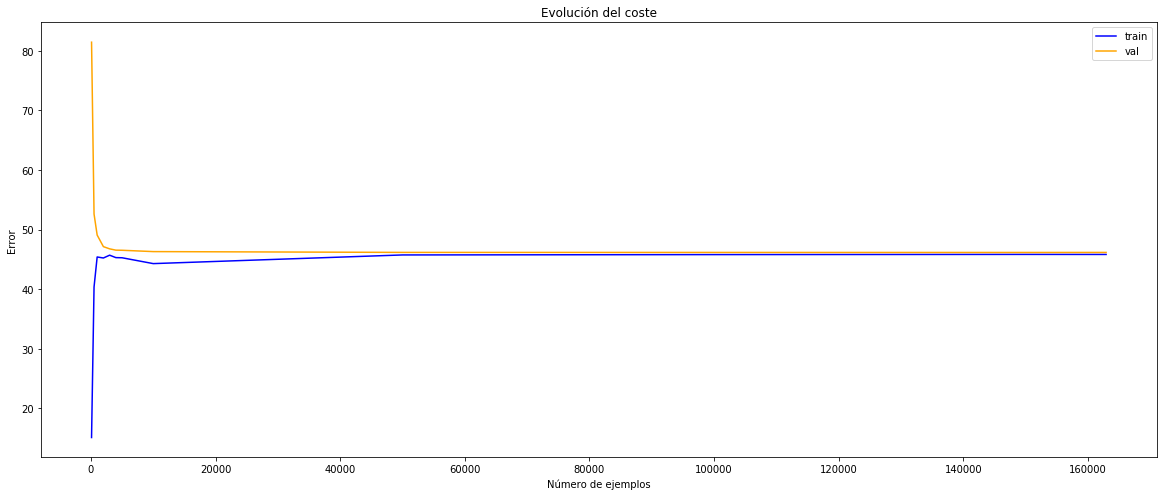

In [25]:
errors_train =  []
errors_val = []
sizes = [100,500,1000,2000,3000,4000,5000,10000,50000,100000,150000,162907]

for size in sizes:
    #Get new sets
    new_train = train[:size]
    new_val = val
    X_train_local = np.array(new_train[features])
    Y_train_local = np.array(new_train[target])
    X_val_local = np.array(new_val[features])
    Y_val_local = np.array(new_val[target])
    
    
    #Train with this size
    initial_thetas = np.zeros(X_train.shape[1])
    thetas = optimize.minimize(fun=linearCostGrad,
                                   x0=initial_thetas,
                                   args=(X_train_local,Y_train_local),
                                   method='TNC',
                                   jac=True).x
    
    
    #Get error
    errors_train.append(cost(thetas,X_train_local,Y_train_local))
    errors_val.append(cost(thetas,X_val_local,Y_val_local))

plt.figure(figsize=(20,8))
plt.plot(sizes,errors_train, color="blue")
plt.plot(sizes,errors_val, color="orange")
plt.legend(['train', 'val'])
plt.ylabel('Error')
plt.xlabel('Número de ejemplos')
plt.title("Evolución del coste")

Como podemos observar, con 50.000 datos de entrenamiento ambos conjuntos convergen por lo que no interesaría introducir más datos para intentar aumentar la precisión. Tras esto crearemos una curva de validación para determinar el mejor hiperparámetro reg, utilizando el conjunto de entrenamiento con el tamaño de 50.000 ejemplos

### Curva de validación

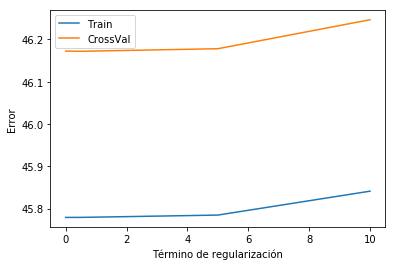

In [26]:
reg =[0, 0.01, 0.1, 0.5, 1, 5, 10]
errors_train = []
errors_val = []

for i in reg:
    initial_thetas = np.zeros(X_train.shape[1])
    thetas = optimize.minimize(fun=linearCostGrad,
               x0=initial_thetas,
               args=(X_train,Y_train,i),
               method='TNC',
               jac=True).x

    errors_train.append(cost(thetas,X_train[:50000],Y_train[:50000],0))
    errors_val.append(cost(thetas,X_val,Y_val,0))

plt.plot(reg,errors_train, label='Train')
plt.plot(reg,errors_val, label='CrossVal')
plt.ylabel('Error')
plt.xlabel('Término de regularización')
plt.legend()

Aunque tiene una mejora prácticamente nula, se puede ver que el mejor valor es sin término de regularización.

Probamos en los datos "test" con la mejor configuración obtenida.

In [27]:
initial_thetas = np.zeros(X_train.shape[1])
thetas = optimize.minimize(fun=linearCostGrad,
                           x0=initial_thetas,
                           args=(X_train[:50000],Y_train[:50000],0),
                           method='TNC',
                           jac=True).x
linearCostGrad(thetas_opt,X_test,Y_test)

(46.884648074815054,
 array([ 2.35118590e-02,  5.36124517e-02,  2.84992374e+04,  4.87465219e-02,
         4.28033507e-03,  7.87433057e-03,  4.66343898e-02,  1.10109260e-02,
         8.11912707e+00,  2.75074429e-02,  1.99177668e-02, -1.54242367e-02,
         2.17565201e-02,  2.83411973e-02, -1.15422705e-02,  7.97334880e-03,
         4.91227481e-04, -1.79693830e-02,  3.45628591e-02,  1.37315009e-02,
        -1.92833027e-02,  1.82504930e-02,  4.56784980e-04, -5.27603720e-03,
         1.37060638e-02, -8.59079952e-03,  8.77716254e-03,  2.41451886e-02,
         3.80127614e-03, -1.64664001e-02,  1.36921287e-03,  9.60210661e-03,
         1.16082469e-03, -6.18699645e-03, -1.55010562e-03,  1.45926338e-03,
        -1.53044903e-02, -4.30988552e-03,  2.26427481e-03, -8.67153612e-03,
         1.66594994e-03,  2.40148996e-03,  3.47049209e-02,  5.72756010e-03,
         8.57179356e-03,  2.27075023e-02, -2.24639409e-04, -7.88811764e-03]))

La mejor configuración obtenida es utilizar 50.000 ejemplos del conjunto de entrenamiento y utilizar como parámtro de regularización = 0, obteniendo un error de 46.8

## Regresión Lineal de Scikit-learn

En este apartado se realizarán pruebas con el algorítmo de Regresión Lineal de la librería de scikit-learn. Primero entrenaremos con los datos de entrenamiento, para después obtener obtendremos el porcentaje de precisión sobre los datos de validación y tras ello se aplicarán diferentes configuraciones, para finalmente realizar predicciones sobre el tercer conjunto de datos, Test.

In [115]:
model = LinearRegression()
model.fit(X=X_train, y=Y_train)
print("La precisión sobre los datos de validación es: {} % ".format(model.score(X_val, Y_val) * 100))

La precisión sobre los datos de validación es: 71.94061702866178 % 


### Curva de aprendizaje

Text(0.5, 1.0, 'Evolución de la precisión')

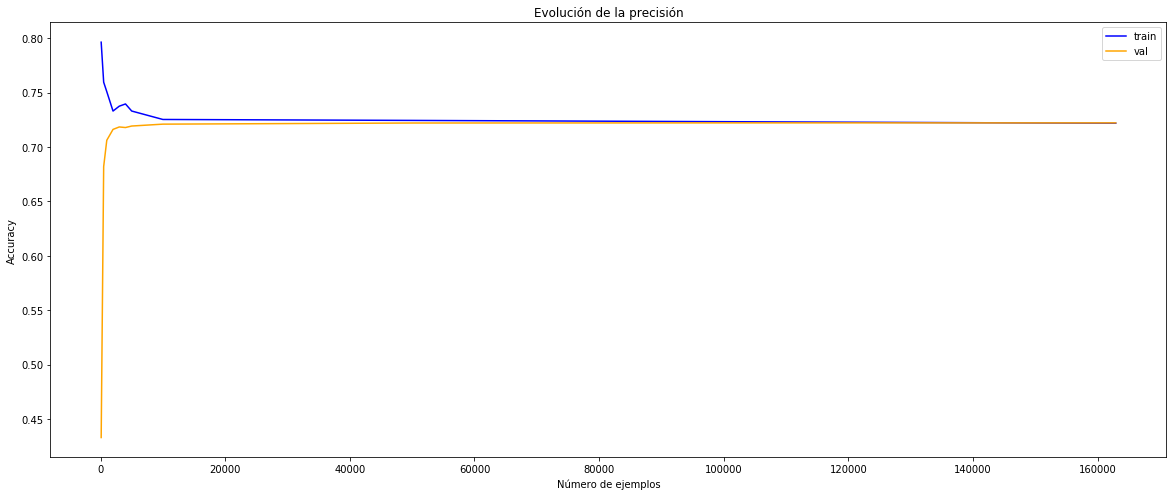

In [116]:
acc_train =  []
acc_val = []
sizes = [100,500,1000,2000,3000,4000,5000,10000,50000,100000,150000,162907]

for size in sizes:
    #Get new sets
    new_train = train[:size]
    new_val = val
    X_train_local = np.array(new_train[features])
    Y_train_local = np.array(new_train[target])
    X_val_local = np.array(new_val[features])
    Y_val_local = np.array(new_val[target])
    
    model = LinearRegression()
    model.fit(X=X_train_local, y=Y_train_local, sample_weight=size)
    
    
    #Get error
    acc_train.append(model.score(X_train_local, Y_train_local))
    acc_val.append(model.score(X_val_local, Y_val_local))

plt.figure(figsize=(20,8))
plt.plot(sizes,acc_train, color="blue")
plt.plot(sizes,acc_val, color="orange")
plt.legend(['train', 'val'])
plt.ylabel('Accuracy')
plt.xlabel('Número de ejemplos')
plt.title("Evolución de la precisión")

Como podemos observar, al igual que con el algorítmo realizado por nosotros, con 50.000 datos de entrenamiento ambos conjuntos convergen por lo que no interesaría introducir más datos para intentar aumentar la precisión. Tras esto crearemos una curva de validación para determinar el mejor hiperparámetro reg, utilizando el conjunto de entrenamiento con el tamaño de 50.000 ejemplos

### Curvas de validación

Para realizar regresión lineal con regularización, utilizaremos Ridge Regression de Scikit-learn

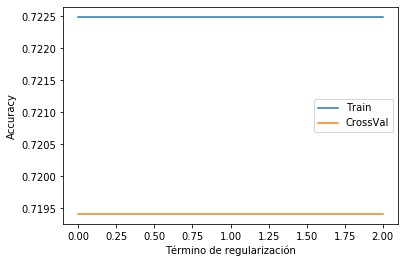

In [117]:
reg =[0.001, 0.01, 0.1, 1, 2]
acc_train = []
acc_val = []

for i in reg:
    model = None
    model = Ridge(alpha=i)
    model.fit(X=X_train, y=Y_train, sample_weight=50000)
    
    #Get error
    acc_train.append(model.score(X_train, Y_train))
    acc_val.append(model.score(X_val, Y_val))

plt.plot(reg,acc_train, label='Train')
plt.plot(reg,acc_val, label='CrossVal')
plt.ylabel('Accuracy')
plt.xlabel('Término de regularización')
plt.legend()

Nos quedamos con la mejor configuración, sin parámetro de regularización.
Y comprobamos con los datos de Test.

In [118]:
model = LinearRegression()
model.fit(X=X_train, y=Y_train, sample_weight=50000)
model.score(X_test, Y_test)

0.7227773629331583

## Regresión Logística

Previamente, dado que actuamente la variable popularidad es una variable continua deberemos discretizarla,para ello se escogerá la columna 'popularity class' como variable objetivo donde:
- Alta (2): Popularidad > 70
- Popularidad Media (1) : 40 <= Popularidad <= 70
- Popularidad Baja (0): Popularidad < 40

In [28]:
X_train = np.array(train[features])
Y_train = np.array(train[target_classified])
X_val = np.array(val[features])
Y_val = np.array(val[target_classified])
X_test = np.array(test[features])
Y_test = np.array(test[target_classified])

### Regresión Logística Implementada

Probaremos la precisión obtenida con la implementación realziada en las prácticas

In [29]:
log_reg = OurLogisticRegression(num_features=X_train.shape[1],num_labels=3)

In [30]:
log_reg.fit(X=X_train, Y=Y_train)

In [31]:
log_reg.score(Y_val,log_reg.predict(X_val))

83.20120313674938

En esta primera prueba hemos obtenido una precisión del 83%, para estudiar distintas configuraciones aplicaremos curvas de validación, con el objetivo de ver cual es el mejor hiperparámetro reg

#### Curva de aprendizaje

Text(0.5, 1.0, 'Evolución de la precisión')

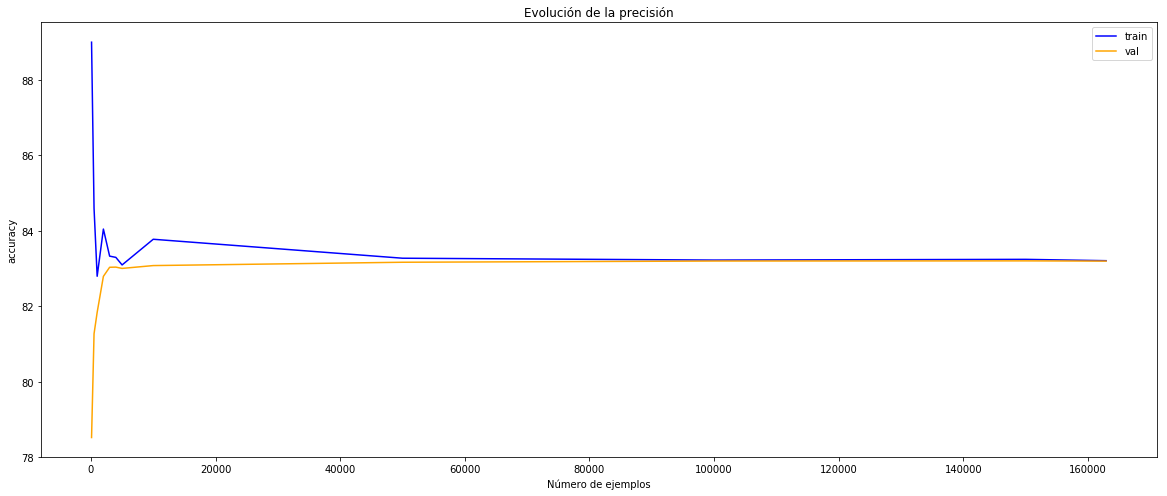

In [33]:
sizes = [100,500,1000,2000,3000,4000,5000,10000,50000,100000,150000,162907]
acc_train_list = []
acc_val_list = []

for size in sizes:
    
    #Get new sets
    new_train = train[:size]
    new_val = val 
    X_train_local = np.array(new_train[features])
    Y_train_local = np.array(new_train[target_classified])
    X_val_local = np.array(new_val[features])
    Y_val_local = np.array(new_val[target_classified])
    
    #Train with this size
    log_reg = OurLogisticRegression(num_features=X_train_local.shape[1],num_labels=3)
    log_reg.fit(X_train_local, Y_train_local)
    #Get acc
    acc_train = log_reg.score(Y_train_local,log_reg.predict(X_train_local))
    acc_val = log_reg.score(Y_val_local,log_reg.predict(X_val_local))
    acc_train_list.append(acc_train)
    acc_val_list.append(acc_val)

plt.figure(figsize=(20,8))
plt.plot(sizes,acc_train_list, color="blue")
plt.plot(sizes,acc_val_list, color="orange")
plt.legend(['train', 'val'])
plt.ylabel('accuracy')
plt.xlabel('Número de ejemplos')
plt.title("Evolución de la precisión")

Como podemos observar en las gráficas anteriores a partir de conjutnos de entrenamiento de 50.000 elementos comienzan a converger la precisión en validación y entrenamiento, por lo que no interesaría introducir más datos y estudiar el modelo con esos tamaños.

#### Curvas de validación

Comprobamos como evoluciona la precisión en función del parámetro de regualrización:
    

Text(0.5, 1.0, 'Evolución de la precisión en función de la regularización')

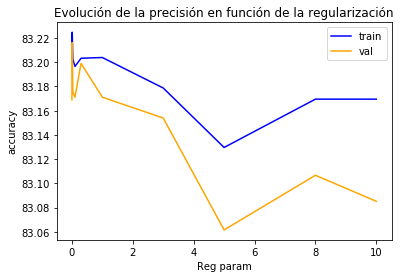

In [35]:
regs = [0, 0.01, 0.03, 0.1, 0.3, 1, 3, 5, 8, 10]
acc_train_list = []
acc_val_list = []
for reg in regs:
    log_reg = OurLogisticRegression(num_features=X_train.shape[1],num_labels=3,reg=reg)
    log_reg.fit(X=X_train[:50000], Y=Y_train[:50000])
    acc_train = log_reg.score(Y_train,log_reg.predict(X_train))
    acc_val = log_reg.score(Y_val,log_reg.predict(X_val))
    acc_train_list.append(acc_train)
    acc_val_list.append(acc_val)

plt.plot(regs,acc_train_list, color="blue")
plt.plot(regs,acc_val_list, color="orange")
plt.legend(['train', 'val'])
plt.ylabel('accuracy')
plt.xlabel('Reg param')
plt.title("Evolución de la precisión en función de la regularización")

Se ha escogido como parámetro de regularización 0.01, ya que es el que mayor precisión otorga al conjunto de validación. Una vez seleccionado el parámetro de regularización procedemos a crear un modelo con dicho parámetro, entrarlo con los datos de entrenamiento y obtener resultado para el nuevo conjunto de datos de test.

In [37]:
log_reg = OurLogisticRegression(num_features=X_train.shape[1],num_labels=3,reg=0.01)
log_reg.fit(X=X_train[:50000], Y=Y_train[:50000])
print("La precisión del algoritmo implementado por los alumnos es: {}".format(log_reg.score(Y_test,log_reg.predict(X_test))))

La precisión del algoritmo implementado por los alumnos es: 83.09199501568341


Como conclusión a la Regresión Logísitca implementada, se ha obtenido una precisión del 83.09%

### Regresión Logística Scikit-learn

En este apartado se realizarán pruebas sobre los diferentes modelos de optimización existentes en Regresión Logística en la librería de scikit-learn. Primero obtendremos el algoritmo con mayor porcentaje de precisión sobre los datos de validación y tras ello se aplicarán diferentes configuraciones, para finalmente realizar predicciones sobre el tercer conjunto de datos, Test.

In [38]:
models = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

In [39]:
for solver in models:
    if solver == "liblinear":
        model = LogisticRegression(solver=solver)
    else: 
        model = LogisticRegression(solver=solver, multi_class ="multinomial")
    model.fit(X=X_train, y=Y_train)
    print("La precisión con el algoritmo {} sobre los datos de validación es: {} % ".format(solver, model.score(X_val, Y_val) * 100))

La precisión con el algoritmo newton-cg sobre los datos de validación es: 83.00999033193683 % 
La precisión con el algoritmo lbfgs sobre los datos de validación es: 53.004619185734235 % 
La precisión con el algoritmo liblinear sobre los datos de validación es: 53.842517993339776 % 
La precisión con el algoritmo sag sobre los datos de validación es: 53.004619185734235 % 
La precisión con el algoritmo saga sobre los datos de validación es: 53.004619185734235 % 


Escogemos el algoritmo de optimización newton-cg y creamos curva de aprendizaje

#### Curva de aprendizaje

Text(0.5, 1.0, 'Evolución de la precisión')

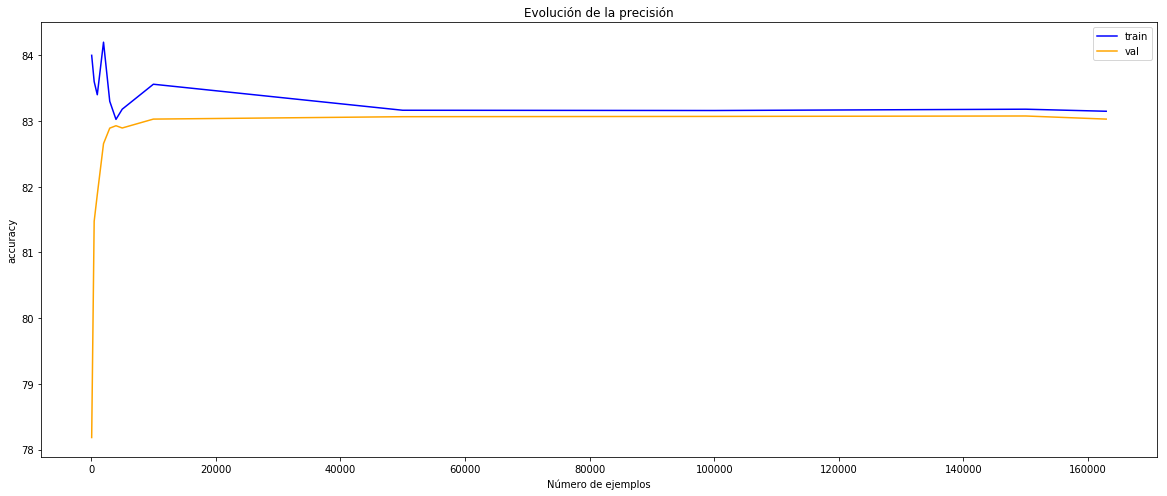

In [41]:
sizes = [100,500,1000,2000,3000,4000,5000,10000,50000,100000,150000,162907]
acc_train_list = []
acc_val_list = []

for size in sizes:
    
    #Get new sets
    new_train = train[:size]
    new_val = val 
    X_train_local = np.array(new_train[features])
    Y_train_local = np.array(new_train[target_classified])
    X_val_local = np.array(new_val[features])
    Y_val_local = np.array(new_val[target_classified])
    
    #Train with this size
    model = LogisticRegression(solver='newton-cg', multi_class ="multinomial", C=1.5)
    model.fit(X=X_train_local, y=Y_train_local)
    #Get acc
    acc_train = log_reg.score(Y_train_local,model.predict(X_train_local))
    acc_val = log_reg.score(Y_val_local,model.predict(X_val_local))
    acc_train_list.append(acc_train)
    acc_val_list.append(acc_val)

plt.figure(figsize=(20,8))
plt.plot(sizes,acc_train_list, color="blue")
plt.plot(sizes,acc_val_list, color="orange")
plt.legend(['train', 'val'])
plt.ylabel('accuracy')
plt.xlabel('Número de ejemplos')
plt.title("Evolución de la precisión")

Como podemos observar en las gráficas anteriores a partir de conjutnos de entrenamiento de 50.000 elementos comienzan a converger la precisión en validación y entrenamiento, por lo que no interesaría introducir más datos y estudiar el modelo con esos tamaños.

#### Curva de validación

In [42]:
C_params = [0.1, 0.5, 1 ,1.5, 2, 3, 5, 10]
acc_train_list = []
acc_val_list= []
best_param = None
best_acc = 0
for C in C_params:
    model = LogisticRegression(solver='newton-cg', multi_class ="multinomial", C=C)
    model.fit(X=X_train[:50000], y=Y_train[:50000])
    acc_train_list.append(log_reg.score(Y_train,model.predict(X_train)))
    acc_val_list.append(log_reg.score(Y_val,model.predict(X_val)))  

Text(0.5, 1.0, 'Evolución de la precisión en función del parámetro C')

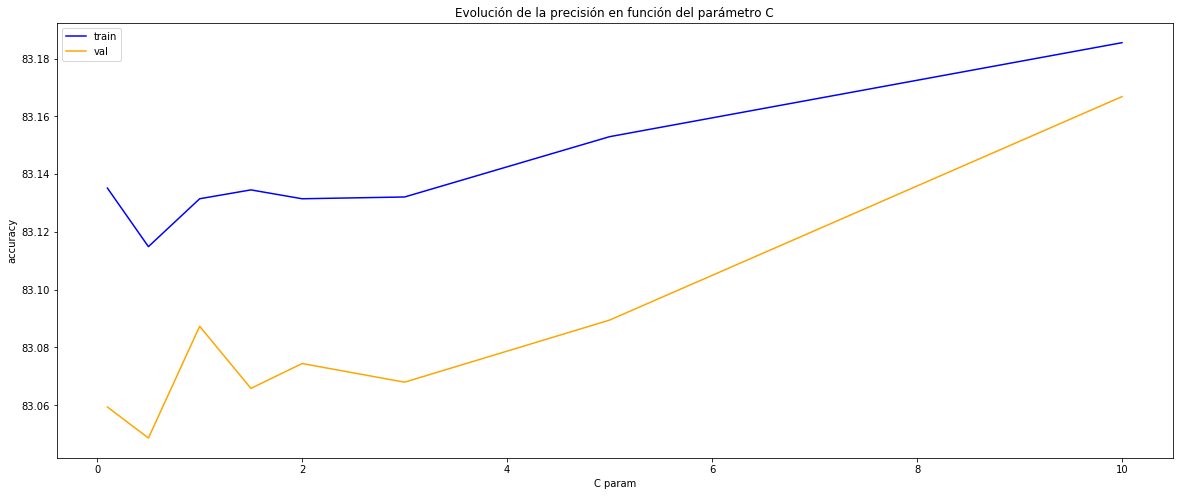

In [43]:
plt.figure(figsize=(20,8))
plt.plot(C_params,acc_train_list, color="blue")
plt.plot(C_params,acc_val_list, color="orange")
plt.legend(['train', 'val'])
plt.ylabel('accuracy')
plt.xlabel('C param')
plt.title("Evolución de la precisión en función del parámetro C")

Tras obtener la mejor configuración (C=10) ,la aplicamos al tercer conjunto de datos

In [45]:
model = LogisticRegression(solver='newton-cg', multi_class ="multinomial", C=10)
model.fit(X=X_train[:50000], y=Y_train[:50000])
print("La precisión del algoritmo implementado por la librería scikit-learn es: {}".format(log_reg.score(Y_test,log_reg.predict(X_test))))

La precisión del algoritmo implementado por la librería scikit-learn es: 83.09199501568341


Como conlusión a la Regresión Logísitca implementada por la librería de scikit-learn, se ha obtenido una precisión del 83.09%

Como conclusión a este apartado de Regresión Logística podemos afirmar que la mejor precisión obtenida tanto por la implementación realizada por los alumnos como la librería scikit learn, otorgan una precisión del 83,09%.

## Redes Neuronales

In [119]:
def sigmoid(X):
    return 1 / (1 + np.exp(-X))

def sigmoid_prime(z):
    return sigmoid(z) * (1 - sigmoid(z))

def random_weights(L_in, L_out, epsilon = 0.0001):
    return np.random.random((L_in, L_out)) * (2 * epsilon) - epsilon

# Forward propagation
def forward_propagate(X, theta1, theta2):
    m = X.shape[0]

    a1 = np.hstack([np.ones([m, 1]), X])
    z2 = np.dot(a1, theta1.T)
    a2 = np.hstack([np.ones([m, 1]), sigmoid(z2)])
    z3 = np.dot(a2, theta2.T)
    h = sigmoid(z3)

    return a1, z2, a2, z3, h

In [ ]:
# Gradient function
def gradient(x, y, theta1,theta2, reg = 0):
    m = x.shape[0]
    
    delta1 = np.zeros(theta1.shape)  # (25, 401)
    delta2 = np.zeros(theta2.shape)  # (10, 26)

    a1, z2, a2, z3, h = forward_propagate(x, theta1, theta2)

    
    #print("Theta1:{}".format(random_theta1.shape))
    #print("Theta2:{}".format(random_theta2.shape))
    
    for t in range(m):    
        a1t = a1[t, :] 
        #print("A1:{}".format(a1.shape))
        a2t = a2[t, :] 
        #print("A2:{}".format(a2.shape))
        ht = h[t, :]  
        #print("H:{}".format(ht.shape))
        yt = y[t]  
        #print("yt:{}".format(yt.shape))        
        d3t = ht - yt  
        #print("d3t:{}".format(d3t.shape))        
        d2t = np.dot(theta2.T, d3t) * (a2t * (1 - a2t)) 
        #print("d2t:{}".format(d2t.shape))
        delta1 = delta1 + np.dot(d2t[1:, np.newaxis], a1t[np.newaxis, :])
        delta1[1:, :] += (theta1[1:, :] * (reg / m))
        #print("delta1:{}".format(delta1.shape))
        delta2 = delta2 + np.dot(d3t[:, np.newaxis], a2t[np.newaxis, :])
        delta2[1:, :] += (theta2[1:, :] * (reg / m))
        #print("delta2:{}".format(delta2.shape))
    
    return np.concatenate((np.ravel(delta1 / x.shape[0]) , np.ravel(delta2 / x.shape[0])))

In [ ]:
def cost(X, y, theta1, theta2, num_etiquetas, reg=0):
    a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
    m = X.shape[0]

    J = 0
    for i in range(m):
        J += np.sum(-y[i] * np.log(h[i]) - (1 - y[i]) * np.log(1 - h[i]))
    J = J / m

    sum_theta1 = np.sum(np.square(theta1[:, 1:]))
    sum_theta2 = np.sum(np.square(theta2[:, 1:]))

    term_3 = (sum_theta1 + sum_theta2) * (reg / (2 * m))

    return J + term_3


In [ ]:
# Cost function
def backprop(params_rn, num_entradas, num_ocultas, num_etiquetas, X, y, reg):
    """ backprop devuelve el coste y el gradiente de una red neuronal de dos capas """
    theta1 = np.reshape(params_rn[:num_ocultas * (num_entradas + 1)], (num_ocultas, (num_entradas + 1)))
    theta2 = np.reshape(params_rn[num_ocultas * (num_entradas + 1):], (num_etiquetas, (num_ocultas + 1)))

    return cost(X, y, theta1, theta2, num_etiquetas, reg), gradient(X, y, theta1, theta2)

In [120]:
def predict_nn(X, h):
    return [(np.argmax(h[image]) + 1) for image in range(X.shape[0])]

## Máquinas de vector de soporte

Previamente, dado que actuamente la variable popularidad es una variable continua deberemos discretizarla,para ello se escogerá la columna 'popularity class' como variable objetivo donde:
- Alta (2): Popularidad > 70
- Popularidad Media (1) : 40 <= Popularidad <= 70
- Popularidad Baja (0): Popularidad < 40

Dado que esta técnica tiene un coste en tiempo muy elevado, antes de realizar curvas de validación se ha optado por añadir curvas de aprendizaje para conocer a partir de qué cantidad de datos no se adquiere una mejora sustancial del modelo.Se estudiará el comportamiento de dos algoritmos de optimización:

#### Kernel Lineal

Primero, realizamos una curva de aprendizaje para conocer a partir de qué número de ejemplos, dejamos de obtener una mejora sustancial en la precisión del modelo:

##### Curva de aprendizaje

Text(0.5, 1.0, 'Evolución de la precisión')

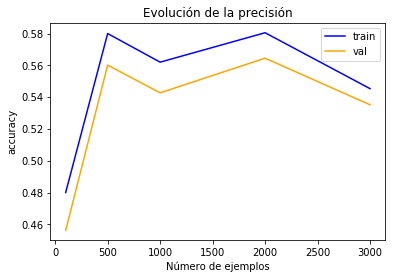

In [53]:
acc_train_list = []
acc_val_list = []
sizes = [100,500,1000,2000,3000]

for size in sizes:
    #Get new sets
    new_train = train[:size]
    new_val = val
    X_train_local = np.array(new_train[features])
    Y_train_local = np.array(new_train[target_classified])
    X_val_local = np.array(new_val[features])
    Y_val_local = np.array(new_val[target_classified])
    #Train with this size
    svm = SVC(kernel='linear')
    svm.fit(X_train_local, Y_train_local)
    #Get acc
    acc_train = accuracy_score(Y_train_local,svm.predict(X_train_local))
    acc_val = accuracy_score(Y_val_local,svm.predict(X_val_local))
    acc_train_list.append(acc_train)
    acc_val_list.append(acc_val)
    
plt.plot(sizes,acc_train_list, color="blue")
plt.plot(sizes,acc_val_list, color="orange")
plt.legend(['train', 'val'])
plt.ylabel('accuracy')
plt.xlabel('Número de ejemplos')
plt.title("Evolución de la precisión")

Como podemos ver en la gráfica anterior, los valores no terminan de converger hacia un mismo punto, por lo que probando con conjuntos mas grándes podamos obtener una mayor precisión, sin embargo no se probará conjutnos de mayor tamaño dado el coste en tiempo de realizarlo

A continuacion, debido a la complejidad en tiempo no se realiza una gráfica de validación, pero si se prueba con valores típicos del parámetro C (C=1, C= 0.01)

In [57]:
svm = SVC(kernel='linear', C=1)
svm.fit(X_train[:2000], Y_train[:2000])
print("La precisión obtenida por SVM con kernel lineal y C=1 es: {}".format(accuracy_score(Y_train,svm.predict(X_train))))

La precisión obtenida por SVM con kernel lineal y C=1 es: 0.5702640156653797


In [58]:
svm = SVC(kernel='linear', C=0.01)
svm.fit(X_train[:2000], Y_train[:2000])
print("La precisión obtenida por SVM con kernel lineal y C=0.01 es  {}".format(accuracy_score(Y_train,svm.predict(X_train))))

La precisión obtenida por SVM con kernel lineal y C=0.01 es  0.568987213563567


#### Kernel rbf

Primero, realizamos una curva de aprendizaje para conocer a partir de qué número de ejemplos, dejamos de obtener una mejora sustancial en la precisión del modelo con las configuraciones predeterminadas de la librería de scikit learn

Text(0.5, 1.0, 'Curva de aprendizaje')

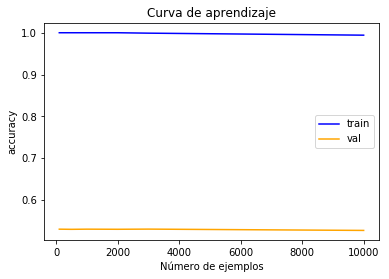

In [47]:
acc_train_list = []
acc_val_list = []
sizes = [100,500,1000,2000,3000,10000]

for size in sizes:
    #Get new sets
    new_train = train[:size]
    new_val = val
    X_train_local = np.array(new_train[features])
    Y_train_local = np.array(new_train[target_classified])
    X_val_local = np.array(new_val[features])
    Y_val_local = np.array(new_val[target_classified])
    #Train with this size
    svm = SVC(kernel='rbf')
    svm.fit(X_train_local, Y_train_local)
    #Get acc
    acc_train = accuracy_score(Y_train_local,svm.predict(X_train_local))
    acc_val = accuracy_score(Y_val_local,svm.predict(X_val_local))
    acc_train_list.append(acc_train)
    acc_val_list.append(acc_val)

plt.plot(sizes,acc_train_list, color="blue")
plt.plot(sizes,acc_val_list, color="orange")
plt.legend(['train', 'val'])
plt.ylabel('accuracy')
plt.xlabel('Número de ejemplos')
plt.title("Curva de aprendizaje")
    

Como podemos ver en la gráfica anterior, a partir de X ejemplos, la precisión en el conjunto de validación no cambia en gran medida. A continuación procedemos a realziar gráficas de validación para conocer el mejor hiperparámetro gamma y C, en estas gráficas se utilzará de tamaño de conjunto de entrenamiento 10000, se ha elegido este puntocomo se podía haber elegido 6000,7000... ya que con todos se obtiene prácticamente la misma precisión en el conjunto de valdiación de la gráfica anterior.

Buscamos el mejor hiperparámetro C

Text(0.5, 1.0, 'Evolución de la precisión en función del parámetro C')

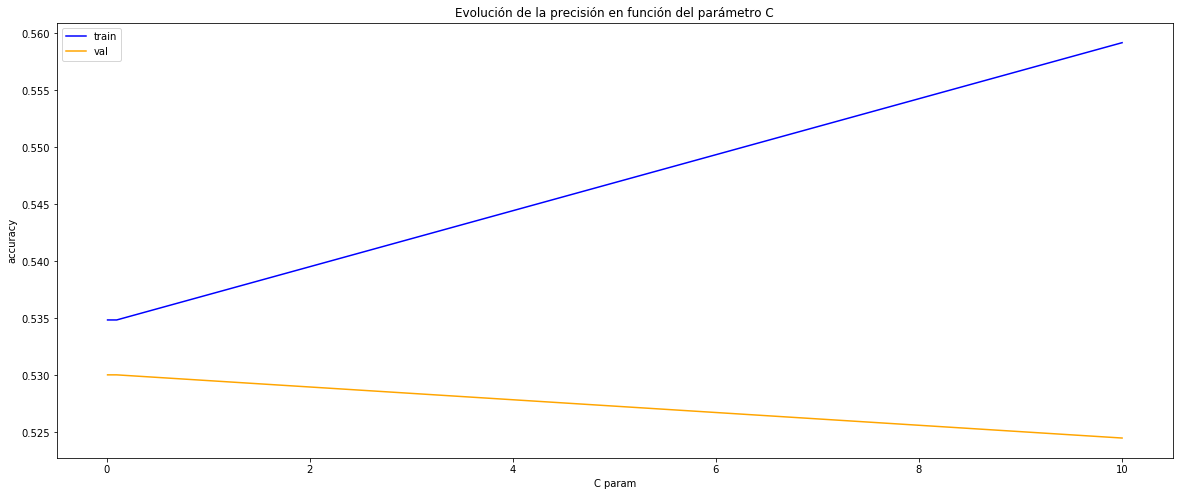

In [49]:
C_params = [0.01,0.1, 10]
acc_train_list = []
acc_val_list= []
for C in C_params:
    svm = SVC(kernel='rbf', C=C)
    svm.fit(X_train[:10000], Y_train[:10000])
    acc_train_list.append(accuracy_score(Y_train,svm.predict(X_train)))
    acc_val_list.append(accuracy_score(Y_val,svm.predict(X_val)))  

plt.figure(figsize=(20,8))
plt.plot(C_params,acc_train_list, color="blue")
plt.plot(C_params,acc_val_list, color="orange")
plt.legend(['train', 'val'])
plt.ylabel('accuracy')
plt.xlabel('C param')
plt.title("Evolución de la precisión en función del parámetro C")

Buscamos el mejor hiperparámetro gamma, utilziando el mejor C obtenido, enbese caso la mejor precisión se obtiene con C = 0.01.

In [50]:
gamma_params = [0.1,'auto','scale']
acc_train_list = []
acc_val_list= []
best_param = None
best_acc = 0
for g in gamma_params:
    svm = SVC(kernel='rbf', C=0.01, gamma=g)
    svm.fit(X_train[:10000], Y_train[:10000])
    acc_val_list.append(accuracy_score(Y_val,svm.predict(X_val)))  
    print("La precisión con C=0.01 y gamma ={} es : {}%".format(g,accuracy_score(Y_val,svm.predict(X_val))))

La precisión con C=0.01 y gamma =0.1 es : 0.5300461918573424%
La precisión con C=0.01 y gamma =auto es : 0.5300461918573424%
La precisión con C=0.01 y gamma =scale es : 0.5866580728327425%


Le mejor configuración obtenida por tanto es utilizar el conjutno de entrenamientro con 10.000 ejemplos, hiperparámetros:
- C = 0.01
- gamma= 1 / (n_features * X.var())  (sckiti-learn metric)

In [51]:
svm = SVC(kernel='rbf', C=0.01, gamma='scale')
svm.fit(X_train[:10000], Y_train[:10000])
print("La precisión obtenida por SVM con kernel rbf con C={}  y gamma={} es {}".format(0.01,'scale',accuracy_score(Y_val,svm.predict(X_val))))

La precisión obtenida por SVM con kernel rbf con C=0.01  y gamma=scale es 0.5866580728327425


La precisión obtenida con Kernel RBF y su mejor configruación C=0.01, gamma=scale es 58.66%

## Conclusiones